In [1]:
# Cell 1 — quick environment + package check (minimal)

import sys

print("Env check")
print(f"Python: {sys.version.split()[0]}")
print(f"Executable: {sys.executable}\n")

required = {
    "pandas": "dataframes",
    "numpy": "arrays",
    "matplotlib": "plots",
    "seaborn": "stats plots",
    "scipy": "scientific utils",
    "sklearn": "ml",
    "requests": "http",
    "pathlib": "paths"
}

missing = []
print("Packages:")
for pkg, note in required.items():
    try:
        __import__(pkg)
        print(f"  ok  - {pkg:10s} ({note})")
    except ImportError:
        print(f"  miss- {pkg:10s} ({note})")
        missing.append(pkg)

if missing:
    print("\nMissing:", ", ".join(missing))
    print("Install with:")
    print("!pip install " + " ".join(missing))
else:
    print("\nAll required packages available.")


Env check
Python: 3.12.12
Executable: /usr/bin/python3

Packages:
  ok  - pandas     (dataframes)
  ok  - numpy      (arrays)
  ok  - matplotlib (plots)
  ok  - seaborn    (stats plots)
  ok  - scipy      (scientific utils)
  ok  - sklearn    (ml)
  ok  - requests   (http)
  ok  - pathlib    (paths)

All required packages available.


In [2]:
# Cell 2 — imports + basic setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
import warnings

warnings.filterwarnings("ignore")

# plotting preferences
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

# make sure data folder exists
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

print("Setup done.")
print(f"pandas  : {pd.__version__}")
print(f"numpy   : {np.__version__}")
print(f"matplotlib : {plt.matplotlib.__version__}")
print(f"seaborn : {sns.__version__}")
print(f"data dir: {data_dir.resolve()}")

Setup done.
pandas  : 2.2.2
numpy   : 2.0.2
matplotlib : 3.10.0
seaborn : 0.13.2
data dir: /content/data


In [3]:
# Cell 3 — download CCLE files (sample info + expression)

import time

def download(url, out_path, desc):
    """Download a file to out_path; print simple status."""
    p = Path(out_path)
    if p.exists():
        mb = p.stat().st_size / (1024*1024)
        print(f"{desc}: exists ({mb:.1f} MB) -> {p}")
        return True

    print(f"{desc}: downloading...")
    try:
        r = requests.get(url, stream=True, timeout=30)
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        wrote = 0
        t0 = time.time()

        with open(p, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if not chunk:
                    continue
                f.write(chunk)
                wrote += len(chunk)
                if total:
                    pct = 100 * wrote / total
                    # minimal progress line
                    print(f"\r  {pct:5.1f}% ", end="")
        dt = time.time() - t0
        mb = (wrote / (1024*1024)) if wrote else 0
        print(f"\r  done ({mb:.1f} MB in {dt:.1f}s)")
        return True
    except Exception as e:
        if p.exists():
            p.unlink()  # remove partial
        print(f"  error: {e}")
        return False

files = {
    "sample_info": {
        "url": "https://ndownloader.figshare.com/files/35020903",
        "name": "ccle_sample_info.csv",
        "desc": "CCLE sample info"
    },
    "expression": {
        "url": "https://ndownloader.figshare.com/files/34989919",
        "name": "ccle_expression.csv",
        "desc": "CCLE expression (RNA-seq)"
    }
}

print("Source: DepMap (Public 23Q4) — https://depmap.org/portal/download/")
ok = {}

for key in ["sample_info", "expression"]:
    info = files[key]
    path = data_dir / info["name"]
    ok[key] = download(info["url"], path, info["desc"])
    time.sleep(0.3)

if all(ok.values()):
    print("\nDownloaded files:")
    for key in ["sample_info", "expression"]:
        p = data_dir / files[key]["name"]
        if p.exists():
            mb = p.stat().st_size / (1024*1024)
            print(f"  - {p.name} ({mb:.1f} MB)")
    print("\nNext → load + explore")
else:
    print("\nSome downloads failed. Check connection and re-run this cell.")

Source: DepMap (Public 23Q4) — https://depmap.org/portal/download/
CCLE sample info: downloading...
  done (0.4 MB in 0.4s)
CCLE expression (RNA-seq): downloading...
  done (408.8 MB in 14.6s)

Downloaded files:
  - ccle_sample_info.csv (0.4 MB)
  - ccle_expression.csv (408.8 MB)

Next → load + explore


In [4]:
# Cell 4 — load sample info + inspect columns

print("Loading CCLE sample info…")
sample_info = pd.read_csv(data_dir / "ccle_sample_info.csv")
print(f"rows: {len(sample_info)}, cols: {sample_info.shape[1]}")

# quick look
display(sample_info.head(3))

# columns that likely describe cancer type / lineage
keywords = ["lineage", "cancer", "disease", "type", "oncotree", "primary"]
cand_cols = [c for c in sample_info.columns if any(k in c.lower() for k in keywords)]

print("\ncandidate cancer-type columns:")
for c in cand_cols:
    uniq = sample_info[c].nunique()
    print(f" - {c} (unique: {uniq})")
    if uniq <= 50:
        print("   sample values:", sample_info[c].value_counts().head(3).to_dict())

print("\nNext → filter SCLC lines")


Loading CCLE sample info…
rows: 1840, cols: 29


,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_V607,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-JnARLB,NaN,Clear cell renal cell carcinoma,C4033,NaN
1,ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Female,DSMZ,CVCL_0089,NaN,...,b_cell,NaN,NaN,NaN,NaN,PT-p2KOyI,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
2,ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN,Female,Academic lab,CVCL_1497,NaN,...,NSCLC_adenocarcinoma,NaN,NaN,NaN,NaN,PT-9p1WQv,NaN,Lung adenocarcinoma,C3512,NaN



candidate cancer-type columns:
 - primary_or_metastasis (unique: 2)
   sample values: {'Primary': 683, 'Metastasis': 515}
 - primary_disease (unique: 33)
   sample values: {'Lung Cancer': 272, 'Leukemia': 137, 'Skin Cancer': 119}
 - Subtype (unique: 174)
 - lineage (unique: 30)
   sample values: {'lung': 274, 'blood': 141, 'skin': 120}
 - lineage_subtype (unique: 105)
 - lineage_sub_subtype (unique: 84)
 - lineage_molecular_subtype (unique: 17)
   sample values: {'EWS_FLI': 20, 'MYCN_amp': 19, 'MSI': 18}
 - Cellosaurus_NCIt_disease (unique: 256)

Next → filter SCLC lines


In [5]:
# Cell 5 — select SCLC cell lines (from sample_info only)

print("Filter to lung lineage…")
lung = sample_info[sample_info["lineage"] == "lung"].copy()
print(f"lung lines: {len(lung)}")

# quick distributions (useful sanity checks)
print("\nprimary_disease (top):")
print(lung["primary_disease"].value_counts().head(10))

print("\nlineage_subtype (top):")
print(lung["lineage_subtype"].value_counts().head(10))

# SCLC mask across a couple of descriptive columns
mask = (
    lung["primary_disease"].fillna("").str.contains("small cell", case=False) |
    lung["lineage_subtype"].fillna("").str.contains("small cell|sclc", case=False)
)

sclc_lines = lung[mask].copy()
print(f"\nSCLC lines: {len(sclc_lines)}")

# keep the few columns we actually need later
cols = ["DepMap_ID", "cell_line_name", "primary_disease", "lineage_subtype"]
cols = [c for c in cols if c in sclc_lines.columns]
display(sclc_lines[cols].head(10))

# IDs for downstream subsetting of expression matrix (Cell 7)
sclc_depmap_ids = sclc_lines["DepMap_ID"].tolist()
print(f"\nSCLC DepMap IDs: {len(sclc_depmap_ids)} found")


Filter to lung lineage…
lung lines: 274

primary_disease (top):
primary_disease
Lung Cancer      272
Non-Cancerous      1
Unknown            1
Name: count, dtype: int64

lineage_subtype (top):
lineage_subtype
NSCLC             156
SCLC               77
mesothelioma       34
lung_carcinoid      4
lung_carcinoma      1
Name: count, dtype: int64

SCLC lines: 233


,DepMap_ID,cell_line_name,primary_disease,lineage_subtype
2,ACH-000033,NCI-H1819,Lung Cancer,NSCLC
29,ACH-000179,NCI-H1618,Lung Cancer,SCLC
45,ACH-000297,NCI-H889,Lung Cancer,SCLC
66,ACH-000523,NCI-H1184,Lung Cancer,SCLC
71,ACH-000553,Sq-1,Lung Cancer,NSCLC
83,ACH-000710,NCI-H854,Lung Cancer,NSCLC
87,ACH-000737,NCI-H1385,Lung Cancer,NSCLC
93,ACH-000813,T3M-10,Lung Cancer,NSCLC
94,ACH-000837,NCI-H322,Lung Cancer,NSCLC
95,ACH-000845,NCI-H1373,Lung Cancer,NSCLC



SCLC DepMap IDs: 233 found


In [6]:
# Cell 6 — load full expression data + extract SCLC subset
import pandas as pd
import numpy as np

print("Loading full CCLE expression data… (can take a minute)")
expression_full = pd.read_csv(data_dir / "ccle_expression.csv", index_col=0)
print(f"loaded: {expression_full.shape[0]} cell lines × {expression_full.shape[1]:,} genes")

# check overlap with our SCLC ids
overlap_ids = [i for i in sclc_depmap_ids if i in expression_full.index]
print(f"SCLC ids with expression: {len(overlap_ids)} / {len(sclc_depmap_ids)}")
assert len(overlap_ids) > 0, "no SCLC IDs matched in expression table."

# subset for SCLC lines only
sclc_expression = expression_full.loc[overlap_ids].copy()

# add readable names
name_map = dict(zip(
    sclc_lines.loc[sclc_lines["DepMap_ID"].isin(overlap_ids), "DepMap_ID"],
    sclc_lines.loc[sclc_lines["DepMap_ID"].isin(overlap_ids), "cell_line_name"]
))
sclc_expression.insert(0, "Cell_Line_Name", sclc_expression.index.map(name_map))

print("\nSCLC subset:")
print(f"  lines: {sclc_expression.shape[0]}  genes: {sclc_expression.shape[1]:,}")
display(sclc_expression.head())

# quick quality check
num = sclc_expression.drop(columns=["Cell_Line_Name"])
print(f"missing values: {num.isna().sum().sum()}  range: [{num.min().min():.2f}, {num.max().max():.2f}]")

print("\nNext → extract key marker genes (Cell 7)")


Loading full CCLE expression data… (can take a minute)
loaded: 1406 cell lines × 19,221 genes
SCLC ids with expression: 185 / 233

SCLC subset:
  lines: 185  genes: 19,222


,Cell_Line_Name,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-000033,NCI-H1819,4.682573,0.000000,6.949185,1.823749,3.837943,0.028569,0.790772,6.224002,4.825786,...,0.443607,0.565597,0.505891,1.794936,0.150560,0.0,0.298658,0.000000,0.000000,0.000000
ACH-000179,NCI-H1618,4.745237,0.000000,6.750740,3.428946,5.033863,0.070389,0.176323,3.508429,4.575312,...,2.821710,4.197708,1.232661,2.060047,0.933573,0.0,3.001802,0.000000,0.400538,0.000000
ACH-000297,NCI-H889,2.226509,0.201634,6.152589,2.292782,3.475085,0.321928,4.178715,4.136684,5.356144,...,0.526069,1.090853,0.739848,1.427606,0.765535,0.0,0.000000,0.000000,0.367371,0.000000
ACH-000523,NCI-H1184,5.000451,0.000000,6.349613,2.821710,4.791814,0.367371,0.028569,2.813525,5.702658,...,1.655352,1.664483,0.584963,2.446256,0.575312,0.0,0.378512,0.097611,0.137504,0.226509
ACH-000553,Sq-1,5.626439,0.000000,6.349790,2.269033,3.938286,0.097611,1.752749,6.003827,6.263598,...,1.117695,1.321928,0.565597,1.432959,0.669027,0.0,0.014355,0.000000,0.028569,0.000000


missing values: 0  range: [0.00, 17.06]

Next → extract key marker genes (Cell 7)


Genes requested: 23 | Found: 22
Missing genes: CD56
TFs: 4/4 -> ASCL1, NEUROD1, YAP1, POU2F3
NE_markers: 4/4 -> INSM1, CHGA, SYP, NCAM1
MYC_family: 3/3 -> MYC, MYCL, MYCN
targets: 7/7 -> BCL2, SOX2, DLL3, GRP, DLK1, HES6, REST
extra: 4/5 -> CALCA, ASCL2, NOTCH1, NOTCH2

Key gene matrix: 185 lines × 22 genes


,Cell_Line_Name,ASCL1,ASCL2,BCL2,CALCA,CHGA,DLK1,DLL3,GRP,HES6,...,MYCN,NCAM1,NEUROD1,NOTCH1,NOTCH2,POU2F3,REST,SOX2,SYP,YAP1
ACH-000033,NCI-H1819,0.000000,1.769772,0.137504,0.000000,0.505891,0.042644,1.761285,0.000000,2.533563,...,4.506526,0.356144,0.014355,0.632268,4.275007,1.189034,3.919340,3.017922,0.782409,6.354205
ACH-000179,NCI-H1618,8.317006,0.000000,4.015248,0.432959,6.039577,10.600749,5.352264,4.298658,7.992429,...,1.944858,4.925525,0.536053,2.295723,2.952334,0.659925,2.555816,4.508429,6.815191,2.176323
ACH-000297,NCI-H889,9.054089,0.042644,6.405482,0.443607,9.476807,0.367371,5.558268,9.093919,7.924040,...,0.000000,7.669877,0.000000,0.669027,1.599318,0.000000,0.895303,5.782933,6.153603,2.392317
ACH-000523,NCI-H1184,9.085499,0.000000,3.182692,0.367371,6.013909,3.734439,7.857608,4.634593,9.870164,...,1.807355,6.970854,2.144046,3.085765,1.292782,0.056584,1.959770,2.722466,5.592756,2.954196
ACH-000553,Sq-1,0.042644,0.000000,0.250962,0.622930,0.042644,0.000000,0.275007,0.028569,1.613532,...,0.000000,0.056584,0.000000,2.784504,5.592756,0.333424,3.173127,0.028569,0.163499,6.062208



Transcription factor statistics:


,mean,std,min,max
ASCL1,1.837179,3.350276,0.0,10.617008
NEUROD1,0.874205,2.127837,0.0,9.068939
YAP1,4.360343,2.343642,0.0,7.723832
POU2F3,0.683816,1.402717,0.0,9.566054


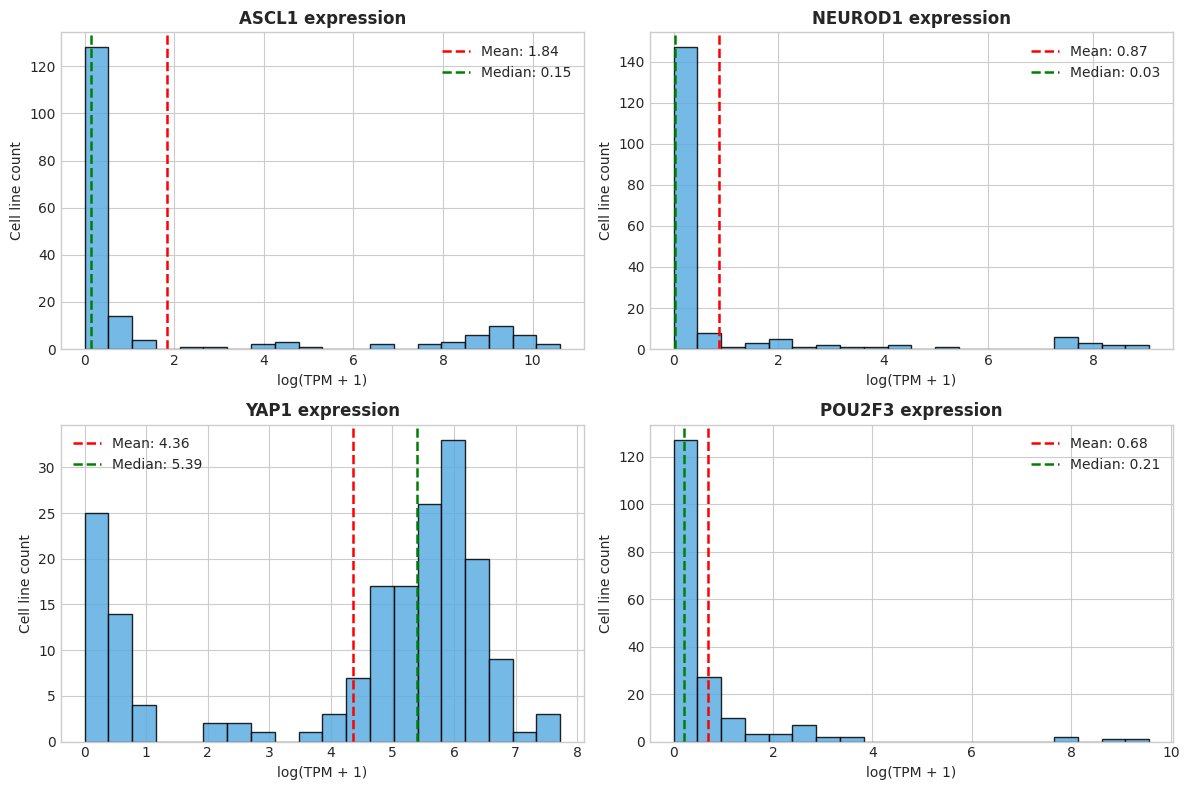

In [7]:
# Cell 7 — Extract key transcription factors and markers (Rudin et al., 2019)

import math

key_sets = {
    "TFs": ["ASCL1", "NEUROD1", "YAP1", "POU2F3"],
    "NE_markers": ["INSM1", "CHGA", "SYP", "NCAM1"],
    "MYC_family": ["MYC", "MYCL", "MYCN"],
    "targets": ["BCL2", "SOX2", "DLL3", "GRP", "DLK1", "HES6", "REST"],
    "extra": ["CD56", "CALCA", "ASCL2", "NOTCH1", "NOTCH2"],
}

# available gene columns (ignore the name column)
gene_cols = [c for c in sclc_expression.columns if c != "Cell_Line_Name"]

def find_gene(g):
    """Find gene column (handles CCLE suffixes like ' (ENSG000...)')."""
    if g in gene_cols:
        return g
    pref = g + " ("
    for c in gene_cols:
        if c.startswith(pref):
            return c
    return None

# flatten + map
all_genes = sorted({g for lst in key_sets.values() for g in lst})
mapped = {g: find_gene(g) for g in all_genes}
found = {g: col for g, col in mapped.items() if col}
missing = [g for g, col in mapped.items() if not col]

print(f"Genes requested: {len(all_genes)} | Found: {len(found)}")
if missing:
    print("Missing genes:", ", ".join(missing))

# per-category summary
for k, lst in key_sets.items():
    got = [g for g in lst if g in found]
    print(f"{k}: {len(got)}/{len(lst)} -> {', '.join(got) if got else '-'}")

# extract subset and rename columns to clean gene symbols
cols = ["Cell_Line_Name"] + [found[g] for g in all_genes if g in found]
key_expr = sclc_expression[cols].copy()
key_expr = key_expr.rename(columns={v: k for k, v in found.items()})

print(f"\nKey gene matrix: {key_expr.shape[0]} lines × {key_expr.shape[1]-1} genes")
display(key_expr.head())

# summarize transcription factors
tfs = ["ASCL1", "NEUROD1", "YAP1", "POU2F3"]
tfs = [t for t in tfs if t in key_expr.columns]

if tfs:
    stats = key_expr[tfs].describe().T[["mean", "std", "min", "max"]]
    print("\nTranscription factor statistics:")
    display(stats)

    # consistent neutral-blue histograms with mean/median markers
    sns.set_style("whitegrid")
    sns.set_palette(["#5dade2"])  # blue tone

    n = len(tfs)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = np.array(axes).ravel() if isinstance(axes, np.ndarray) else np.array([axes])

    for i, g in enumerate(tfs):
        data = key_expr[g].dropna().values
        ax = axes[i]
        ax.hist(data, bins=20, color="#5dade2", edgecolor="black", alpha=0.85)
        mean_v, med_v = np.mean(data), np.median(data)
        ax.axvline(mean_v, color="red", ls="--", lw=1.8, label=f"Mean: {mean_v:.2f}")
        ax.axvline(med_v, color="green", ls="--", lw=1.8, label=f"Median: {med_v:.2f}")
        ax.set_title(f"{g} expression", fontsize=12, fontweight="bold")
        ax.set_xlabel("log(TPM + 1)")
        ax.set_ylabel("Cell line count")
        ax.legend()

    for j in range(i + 1, rows * cols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No TFs found among ASCL1, NEUROD1, YAP1, or POU2F3.")


TFs used: ASCL1, NEUROD1, YAP1, POU2F3
heatmap matrix: 185 lines × 4 TFs


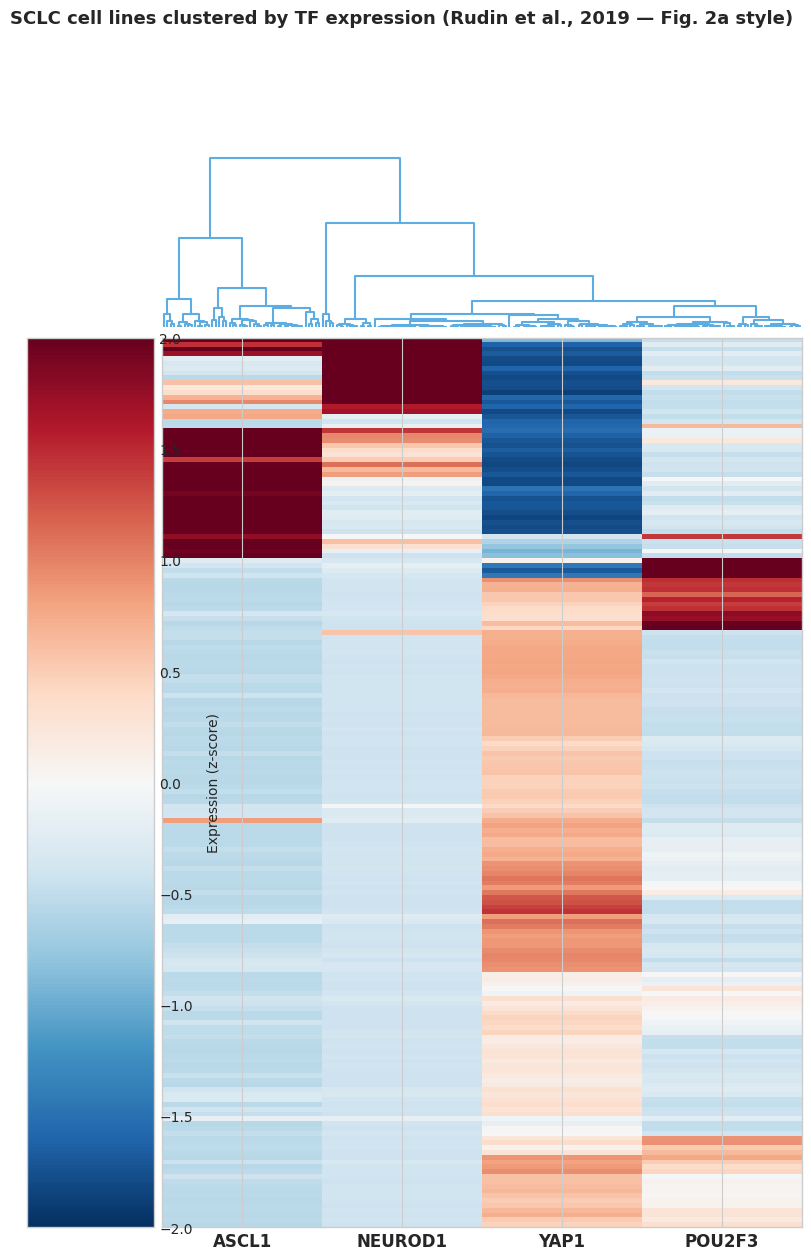


Predicted subtype counts:
SCLC-Y    136
SCLC-A     30
SCLC-N     14
SCLC-P      5
Name: count, dtype: int64


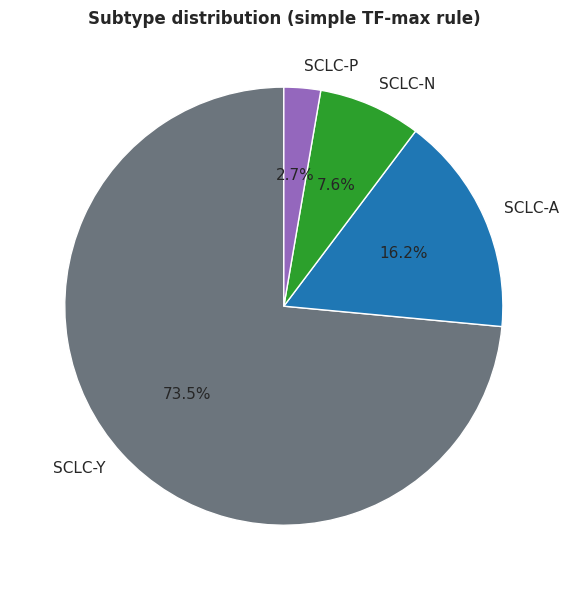


Subtype breakdown (%):
  SCLC-Y: 136 (73.5%)
  SCLC-A: 30 (16.2%)
  SCLC-N: 14 (7.6%)
  SCLC-P: 5 (2.7%)


In [8]:
# Cell 8 — hierarchical clustering heatmap + simple subtype assignment

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# use only the 4 TFs
tfs = ["ASCL1", "NEUROD1", "YAP1", "POU2F3"]
avail_tfs = [g for g in tfs if g in key_expr.columns]  # key_expr is from Cell 7
print(f"TFs used: {', '.join(avail_tfs)}")
assert len(avail_tfs) > 0, "No TFs available for heatmap."

# cell lines × TFs (unscaled for subtype call; scaled for visualization)
heatmap_df = key_expr[avail_tfs].copy()

# scale for visualization
scaler = StandardScaler()
heatmap_scaled = pd.DataFrame(
    scaler.fit_transform(heatmap_df),
    index=key_expr.index,  # same order as key_expr rows (cell lines)
    columns=avail_tfs
)

print(f"heatmap matrix: {heatmap_scaled.shape[0]} lines × {heatmap_scaled.shape[1]} TFs")

# hierarchical clustering (Ward)
Z = linkage(heatmap_scaled, method="ward")

# figure layout: dendrogram + heatmap + colorbar (neutral styling)
sns.set_style("whitegrid")
cmap = "RdBu_r"   # diverging, standard scientific look

fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[1, 5],
                      hspace=0.02, wspace=0.02)

# dendrogram (no labels)
ax_dend = fig.add_subplot(gs[0, 1])
dinfo = dendrogram(Z, ax=ax_dend, no_labels=True, color_threshold=0)
ax_dend.set_xticks([]); ax_dend.set_yticks([])
for side in ("top", "right", "bottom", "left"):
    ax_dend.spines[side].set_visible(False)

# reorder rows according to clustering
order = dinfo["leaves"]
heatmap_ord = heatmap_scaled.iloc[order]

# heatmap
ax_hm = fig.add_subplot(gs[1, 1])
im = ax_hm.imshow(heatmap_ord, aspect="auto", cmap=cmap, vmin=-2, vmax=2)

ax_hm.set_yticks([])
ax_hm.set_xticks(range(len(avail_tfs)))
ax_hm.set_xticklabels(avail_tfs, fontsize=12, fontweight="bold")

# colorbar at left
ax_cb = fig.add_subplot(gs[1, 0])
cb = plt.colorbar(im, cax=ax_cb)
cb.set_label("Expression (z-score)", rotation=90, labelpad=10, fontsize=10)

fig.suptitle(
    "SCLC cell lines clustered by TF expression (Rudin et al., 2019 — Fig. 2a style)",
    fontsize=13, fontweight="bold", y=0.98
)
plt.tight_layout()
plt.show()

# ---- simple subtype assignment (based on unscaled TFs) ----
def tf_to_subtype(tf_name):
    return {
        "ASCL1": "SCLC-A",
        "NEUROD1": "SCLC-N",
        "YAP1": "SCLC-Y",
        "POU2F3": "SCLC-P",
    }.get(tf_name, "Unclassified")

pred = heatmap_df.idxmax(axis=1).map(tf_to_subtype)
key_expr["Predicted_Subtype"] = pred  # keep with the key gene table

counts = pred.value_counts()
print("\nPredicted subtype counts:")
print(counts)

# pie chart with muted, professional colors
fig, ax = plt.subplots(figsize=(8, 6))
subtype_colors = {
    "SCLC-A": "#1f77b4",  # blue
    "SCLC-N": "#2ca02c",  # green
    "SCLC-P": "#9467bd",  # purple
    "SCLC-Y": "#6c757d",  # gray
}
pie_colors = [subtype_colors.get(s, "#999999") for s in counts.index]

ax.pie(
    counts.values,
    labels=counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=pie_colors,
    textprops={"fontsize": 11}
)
ax.set_title("Subtype distribution (simple TF-max rule)", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# quick percentage printout
total = len(key_expr)
print("\nSubtype breakdown (%):")
for s, c in counts.items():
    print(f"  {s}: {c} ({100*c/total:.1f}%)")


,Original(max-TF),Z-rule
SCLC-Y,136,129
SCLC-A,30,30
SCLC-N,14,15
SCLC-P,5,11


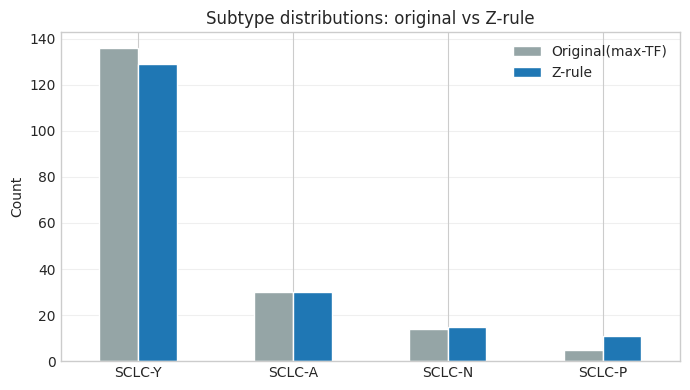


Mean TF expression by Z-rule subtype:


,ASCL1,NEUROD1,YAP1,POU2F3
Subtype_Zrule,,,,
SCLC-A,8.83,1.34,1.00,0.31
SCLC-N,3.36,7.46,0.33,0.19
SCLC-P,0.26,0.16,2.84,3.89
SCLC-Y,0.17,0.06,5.74,0.55


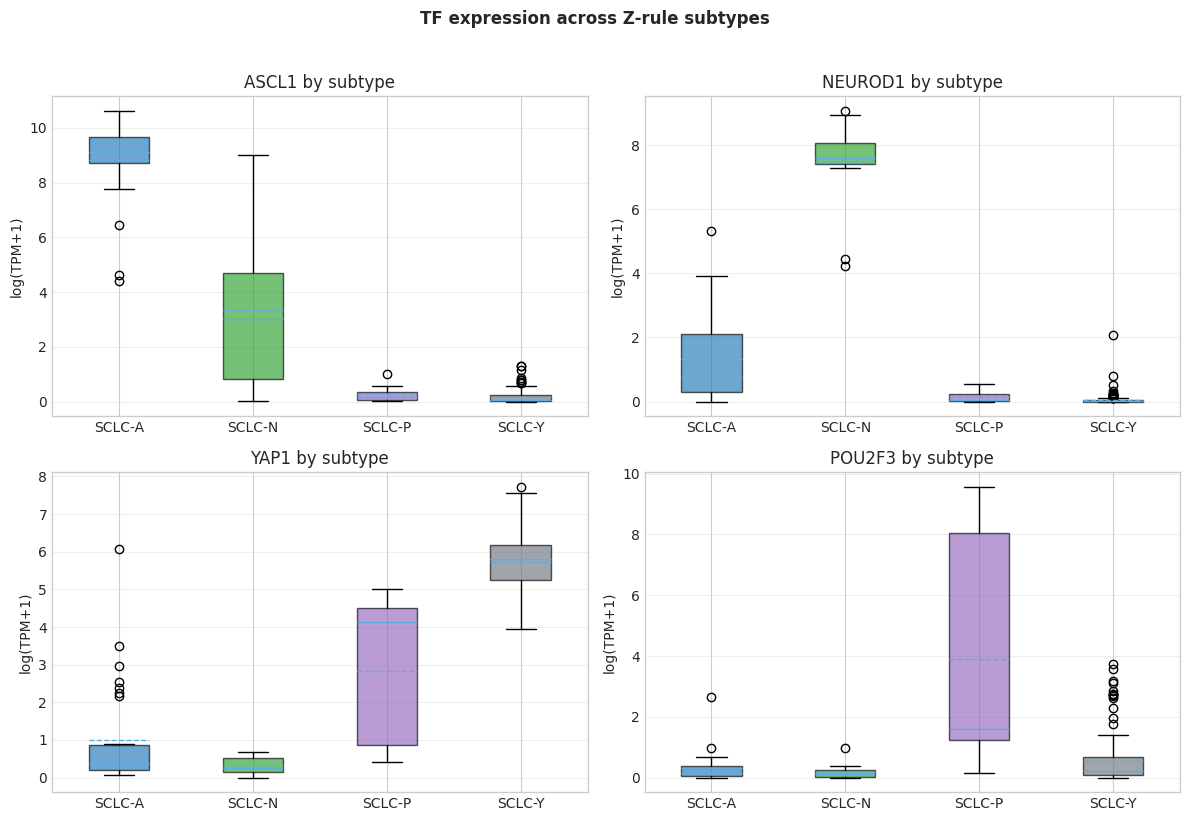

✅ Refined subtype labels stored in key_expr['Subtype_Zrule']


In [9]:
# Cell 9 — Refined subtype classification (Z-score + NE score) + stats/plots

from collections import OrderedDict

# ---------- configuration ----------
# columns to use: the 4 TFs (+ INSM1 if present for NE score)
use_cols = [g for g in ["ASCL1","NEUROD1","YAP1","POU2F3","INSM1"] if g in key_expr.columns]
assert any(g in use_cols for g in ["ASCL1","NEUROD1","YAP1","POU2F3"]), "Need at least one TF."

# thresholds
HIGH_Z = 1.0   # clearly high
MID_Z  = 0.5   # moderate
MARGIN = 0.35  # raw-scale dominance margin (log(TPM+1))
# -----------------------------------

# matrices
X = key_expr[use_cols].copy()                                   # raw (log(TPM+1))
Z = (X - X.mean()) / (X.std().replace(0, 1e-6))                 # z-scores
tf_avail = [g for g in ["ASCL1","NEUROD1","YAP1","POU2F3"] if g in X.columns]

# NE score parts: prefer ASCL1, NEUROD1; add INSM1 if present
ne_parts = [g for g in ["ASCL1","NEUROD1","INSM1"] if g in X.columns]
if len(ne_parts) < 2:
    ne_parts = [g for g in ["ASCL1","NEUROD1"] if g in X.columns]

def classify_z(row):
    rz = {g: row.get(g, 0.0) for g in Z.columns}      # z-scores for available genes
    rv = {g: X.loc[row.name, g] for g in X.columns}   # raw values for dominance checks
    ne_score = sum(rz.get(g, 0.0) for g in ne_parts)

    def dominant(g):
        others = [rv[h] for h in tf_avail if h != g]
        return rv[g] >= (max(others) + MARGIN) if others else True

    # P: POU2F3 clearly high & dominant
    if "POU2F3" in rz and rz["POU2F3"] > HIGH_Z and dominant("POU2F3"):
        return "SCLC-P"

    # N: NEUROD1 high, ASCL1 not high, dominant
    if "NEUROD1" in rz and rz["NEUROD1"] > HIGH_Z and (rz.get("ASCL1", -1e9) <= MID_Z) and dominant("NEUROD1"):
        return "SCLC-N"

    # A: ASCL1 high, NEUROD1 not high, dominant
    if "ASCL1" in rz and rz["ASCL1"] > HIGH_Z and (rz.get("NEUROD1", -1e9) <= MID_Z) and dominant("ASCL1"):
        return "SCLC-A"

    # Y: low neuroendocrine score; allow modest YAP1 support
    if ne_score < 0 and (("YAP1" not in rz) or (rz["YAP1"] > 0.3)):
        return "SCLC-Y"

    # fallback by highest z
    top = max(((g, rz[g]) for g in tf_avail), key=lambda kv: kv[1])[0]
    return {"ASCL1":"SCLC-A","NEUROD1":"SCLC-N","POU2F3":"SCLC-P","YAP1":"SCLC-Y"}.get(top, "Unclassified")

# assign labels (this supersedes earlier "Subtype_Refined")
key_expr["Subtype_Zrule"] = Z.apply(classify_z, axis=1)

# ----- comparison vs original max-TF labels -----
subtype_colors = {"SCLC-A":"#1f77b4","SCLC-N":"#2ca02c","SCLC-P":"#9467bd","SCLC-Y":"#6c757d"}

cols = OrderedDict()
if "Predicted_Subtype" in key_expr.columns:
    cols["Original(max-TF)"] = key_expr["Predicted_Subtype"].value_counts()
cols["Z-rule"] = key_expr["Subtype_Zrule"].value_counts()

comp = pd.DataFrame(cols).fillna(0).astype(int)
display(comp)

ax = comp.plot(kind="bar", figsize=(7,4), rot=0, color=["#95a5a6","#1f77b4"] if "Original(max-TF)" in comp.columns else ["#1f77b4"])
ax.set_ylabel("Count"); ax.set_title("Subtype distributions: original vs Z-rule")
ax.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

# ----- mean TF expression by Z-rule subtype -----
tfs = [g for g in ["ASCL1","NEUROD1","YAP1","POU2F3"] if g in X.columns]
subtype_order = ["SCLC-A","SCLC-N","SCLC-P","SCLC-Y"]

means_tbl = (
    pd.concat([key_expr[tfs], key_expr["Subtype_Zrule"]], axis=1)
      .groupby("Subtype_Zrule")[tfs].mean()
      .reindex(subtype_order)
)
print("\nMean TF expression by Z-rule subtype:")
display(means_tbl.round(2))

# ----- TF boxplots by subtype (neutral style) -----
rows, cols = 2, 2
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
axs = axs.ravel()

for i, g in enumerate(tfs[:rows*cols]):
    ax = axs[i]
    data, labels, colors = [], [], []
    for s in subtype_order:
        vals = key_expr.loc[key_expr["Subtype_Zrule"]==s, g].dropna().values
        if len(vals) > 0:
            data.append(vals); labels.append(s); colors.append(subtype_colors.get(s, "#999999"))
    bp = ax.boxplot(data, labels=labels, patch_artist=True, showmeans=True, meanline=True)
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c); patch.set_alpha(0.65)
    ax.set_title(f"{g} by subtype"); ax.set_ylabel("log(TPM+1)"); ax.grid(axis="y", alpha=0.3)

for j in range(i+1, rows*cols):
    axs[j].set_visible(False)

plt.suptitle("TF expression across Z-rule subtypes", y=1.02, fontsize=12, fontweight="bold")
plt.tight_layout(); plt.show()

print("✅ Refined subtype labels stored in key_expr['Subtype_Zrule']")


📊 DIFFERENTIAL GENE EXPRESSION ANALYSIS (Fig 2c style)
✓ Analyzing 7 genes: MYC, MYCL, MYCN, BCL2, DLL3, INSM1, CHGA

📊 MEAN EXPRESSION BY SUBTYPE


,MYC,MYCL,MYCN,BCL2,DLL3,INSM1,CHGA
Subtype_Zrule,,,,,,,
SCLC-A,3.52,5.87,0.98,4.56,5.87,7.22,7.24
SCLC-N,6.44,4.63,1.40,2.39,4.51,7.45,7.23
SCLC-P,6.15,2.10,2.43,2.94,2.63,2.51,2.34
SCLC-Y,6.21,1.37,0.50,0.94,1.30,0.17,0.75



📈 Creating differential expression plots...


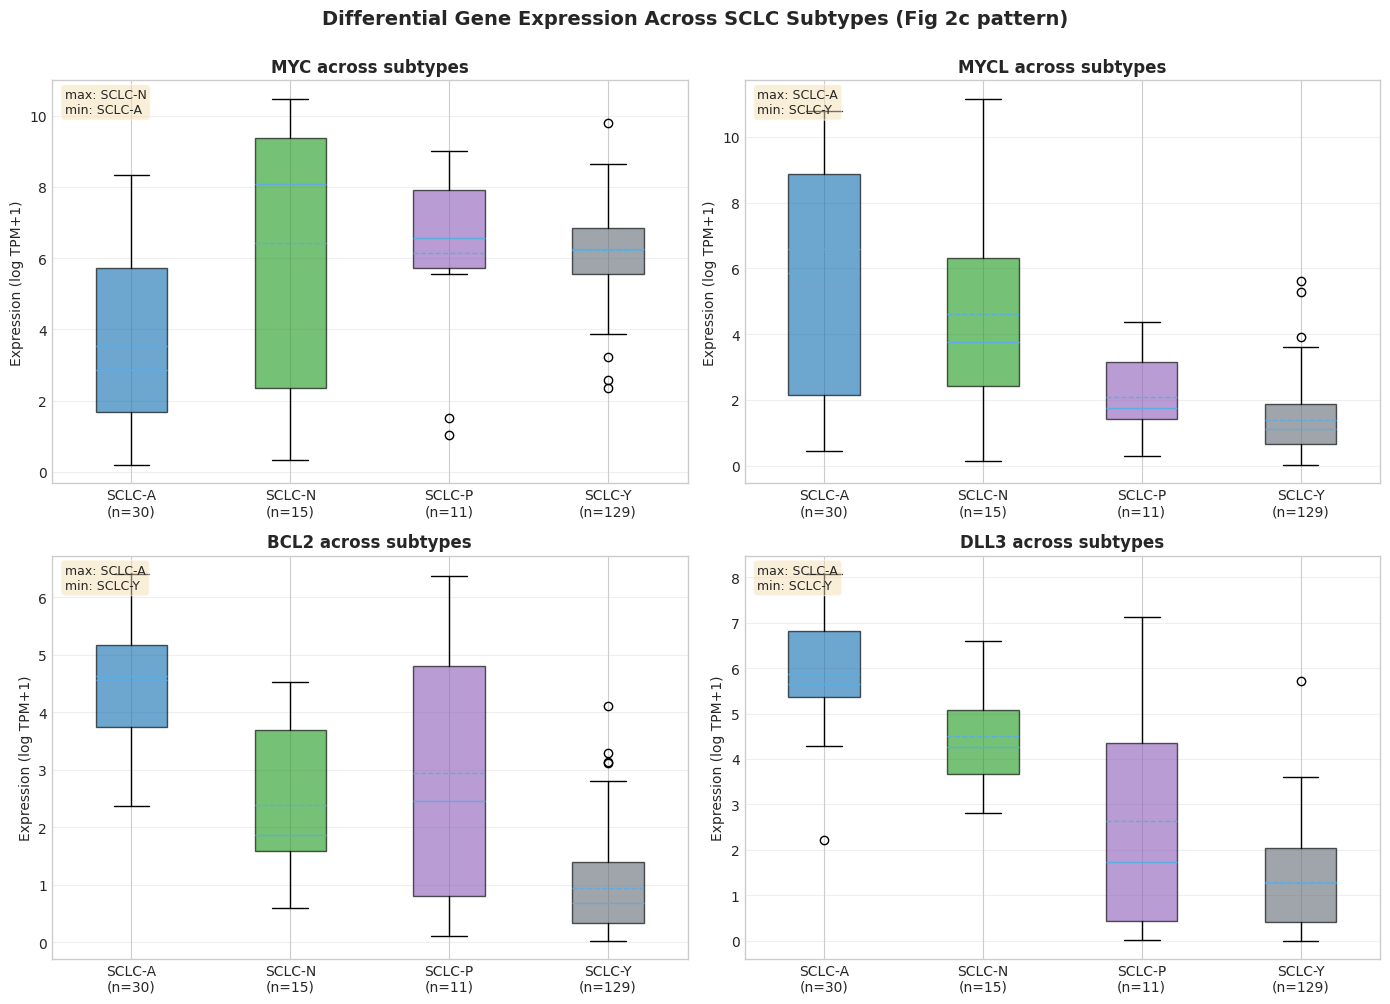


📊 STATISTICAL TESTING (ANOVA across subtypes)
MYC     : F=  18.59, p=1.47e-10  ***
MYCL    : F=  54.59, p=3.51e-25  ***
BCL2    : F= 109.06, p=2.31e-40  ***
DLL3    : F= 137.91, p=1.58e-46  ***

*** p<0.001, ** p<0.01, * p<0.05, ns = not significant

🎯 KEY TAKEAWAYS (aligned with Rudin et al., 2019)
- SCLC-A: tends to show higher MYCL and BCL2; DLL3 often elevated (therapeutic target).
- SCLC-N: shows higher MYC (variant/less neuroendocrine).
- SCLC-P: POU2F3-driven; distinct tuft-cell-like program (smaller cohort).
- SCLC-Y: low neuroendocrine program (ASCL1/NEUROD1 low), YAP1-associated.

 Differential expression cell complete.(Cell 11)


In [10]:
# Cell 10 — Differential Gene Expression (Figure 2c style) using Z-rule labels

print("="*70)
print("📊 DIFFERENTIAL GENE EXPRESSION ANALYSIS (Fig 2c style)")
print("="*70)

from scipy import stats

# --- use the refined labels if present; else fallback to simple ---
label_col = "Subtype_Zrule" if "Subtype_Zrule" in key_expr.columns else "Predicted_Subtype"

# Genes highlighted in Fig 2c
target_genes = {
    "MYC_Family": ["MYC", "MYCL", "MYCN"],
    "Targets": ["BCL2", "DLL3"],
    "Markers": ["INSM1", "CHGA"],
}
fig2c_genes = [g for genes in target_genes.values() for g in genes]

# Work from key_expr so labels & expression are in one table
use_genes = [g for g in fig2c_genes if g in key_expr.columns]
print(f"✓ Analyzing {len(use_genes)} genes:", ", ".join(use_genes))

analysis = key_expr[use_genes + [label_col]].copy()

# --- mean expression by subtype ---
print("\n" + "="*70)
print("📊 MEAN EXPRESSION BY SUBTYPE")
print("="*70)
subtype_order = ["SCLC-A", "SCLC-N", "SCLC-P", "SCLC-Y"]
means_tbl = (
    analysis.groupby(label_col)[use_genes].mean()
    .reindex(subtype_order)
)
display(means_tbl.round(2))

# --- boxplots for the most illustrative genes ---
print("\n📈 Creating differential expression plots...")
genes_to_plot = [g for g in ["MYC", "MYCL", "BCL2", "DLL3"] if g in use_genes]

n = len(genes_to_plot)
if n >= 3:
    n_cols = 2
    n_rows = (n + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
    axes = axes.flatten() if n > 1 else [axes]

    colors = {"SCLC-A":"#1f77b4","SCLC-N":"#2ca02c","SCLC-P":"#9467bd","SCLC-Y":"#6c757d"}

    for i, gene in enumerate(genes_to_plot):
        ax = axes[i]
        plot_data, plot_labels, plot_colors = [], [], []
        for s in subtype_order:
            vals = analysis.loc[analysis[label_col]==s, gene].dropna().values
            if len(vals) > 0:
                plot_data.append(vals)
                plot_labels.append(f"{s}\n(n={len(vals)})")
                plot_colors.append(colors.get(s, "#999999"))

        bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True,
                        showmeans=True, meanline=True)
        for patch, c in zip(bp["boxes"], plot_colors):
            patch.set_facecolor(c); patch.set_alpha(0.65)

        ax.set_title(f"{gene} across subtypes", fontsize=12, fontweight="bold")
        ax.set_ylabel("Expression (log TPM+1)")
        ax.grid(axis="y", alpha=0.3)

        # small helper annotation
        means = [np.mean(d) for d in plot_data]
        ax.text(0.02, 0.98,
                f"max: {plot_labels[int(np.argmax(means))].split()[0]}\n"
                f"min: {plot_labels[int(np.argmin(means))].split()[0]}",
                transform=ax.transAxes, va="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5), fontsize=9)

    # hide any extra panels
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Differential Gene Expression Across SCLC Subtypes (Fig 2c pattern)",
                 fontsize=14, fontweight="bold", y=1.0)
    plt.tight_layout()
    plt.show()

# --- one-way ANOVA per gene ---
print("\n" + "="*70)
print("📊 STATISTICAL TESTING (ANOVA across subtypes)")
print("="*70)

for gene in genes_to_plot:
    groups = [analysis.loc[analysis[label_col]==s, gene].dropna().values
              for s in subtype_order]
    groups = [g for g in groups if len(g) >= 3]  # require minimal n
    if len(groups) >= 2:
        f, p = stats.f_oneway(*groups)
        sig = "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"
        print(f"{gene:8s}: F={f:7.2f}, p={p:.2e}  {sig}")
print("\n*** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# --- concise takeaways you can quote ---
print("\n" + "="*70)
print("🎯 KEY TAKEAWAYS (aligned with Rudin et al., 2019)")
print("="*70)
print(
    "- SCLC-A: tends to show higher MYCL and BCL2; DLL3 often elevated (therapeutic target).\n"
    "- SCLC-N: shows higher MYC (variant/less neuroendocrine).\n"
    "- SCLC-P: POU2F3-driven; distinct tuft-cell-like program (smaller cohort).\n"
    "- SCLC-Y: low neuroendocrine program (ASCL1/NEUROD1 low), YAP1-associated."
)

print("\n Differential expression cell complete.(Cell 11)")


,Subtype,Count,Proportion,CI_95_Lower,CI_95_Upper,Percent
0,SCLC-A,30,0.162,0.116,0.222,16.2
1,SCLC-N,15,0.081,0.050,0.129,8.1
2,SCLC-P,11,0.059,0.034,0.103,5.9
3,SCLC-Y,129,0.697,0.628,0.759,69.7


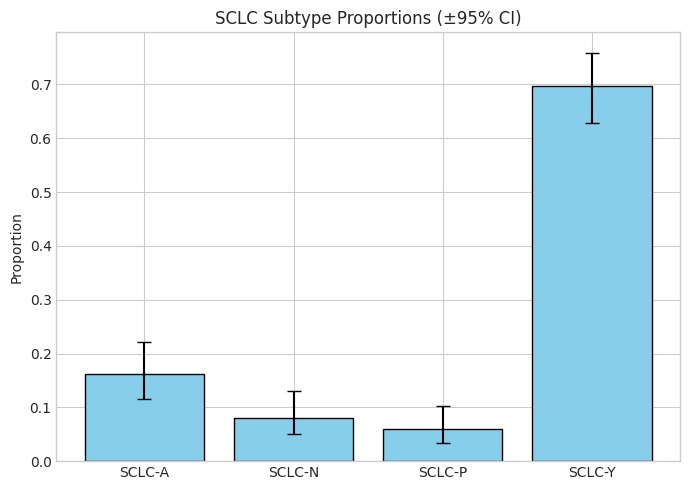

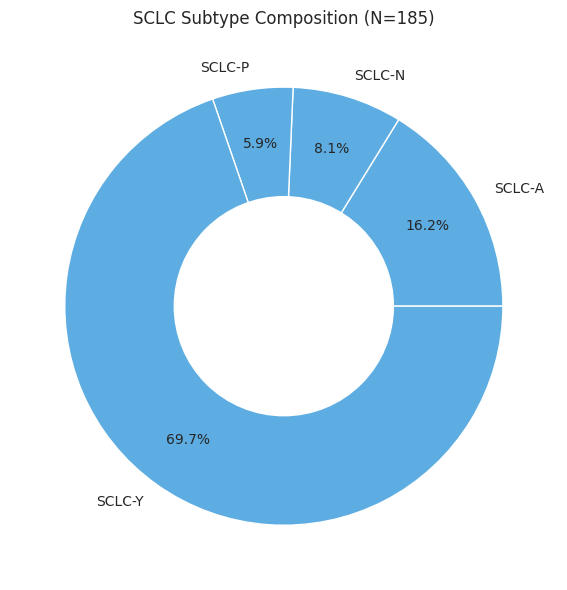

In [11]:
# ============================================================
# 📊 Subtype proportions + 95% CIs (bar with error bars) + donut
# ============================================================

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# --- use your actual dataframe ---
dataset = analysis              # ✅ confirmed from your globals
SUBTYPE_COL = "Subtype_Zrule"   # ✅ column name for subtypes
ORDER = ["SCLC-A", "SCLC-N", "SCLC-P", "SCLC-Y"]

# --- sanity check ---
if SUBTYPE_COL not in dataset.columns:
    raise ValueError(f"Column '{SUBTYPE_COL}' not found. Available columns: {dataset.columns.tolist()}")

# --- Wilson 95% CI ---
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = k / n
    denom = 1 + (z**2)/n
    center = p + (z**2)/(2*n)
    margin = z * math.sqrt((p*(1-p) + (z**2)/(4*n)) / n)
    lower = (center - margin) / denom
    upper = (center + margin) / denom
    return (max(0.0, lower), min(1.0, upper))

# --- compute subtype proportions ---
counts = dataset[SUBTYPE_COL].value_counts().reindex(ORDER, fill_value=0)
N = int(counts.sum())
props = counts / N if N > 0 else counts.astype(float)
ci_bounds = [wilson_ci(int(counts[s]), N) for s in ORDER]
ci_lower = np.array([props[s] - ci_bounds[i][0] for i, s in enumerate(ORDER)])
ci_upper = np.array([ci_bounds[i][1] - props[s] for i, s in enumerate(ORDER)])

# --- summary table ---
summary = pd.DataFrame({
    "Subtype": ORDER,
    "Count": counts.values,
    "Proportion": props.values.round(3),
    "CI_95_Lower": np.array([ci[0] for ci in ci_bounds]).round(3),
    "CI_95_Upper": np.array([ci[1] for ci in ci_bounds]).round(3),
    "Percent": (props.values * 100).round(1)
})
display(summary)

# --- bar chart ---
plt.figure(figsize=(7, 5))
x = np.arange(len(ORDER))
plt.bar(x, props.values, color="skyblue", edgecolor="black")
plt.errorbar(x, props.values, yerr=[ci_lower, ci_upper], fmt='none', capsize=5, color='black')
plt.xticks(x, ORDER)
plt.ylabel("Proportion")
plt.title("SCLC Subtype Proportions (±95% CI)")
plt.tight_layout()
plt.show()

# --- donut chart (compatible with all matplotlib versions) ---
plt.figure(figsize=(6, 6))
pie_output = plt.pie(
    counts.values,
    labels=ORDER,
    autopct=lambda p: f"{p:.1f}%" if p > 0 else "",
    pctdistance=0.75
)

# unpack safely depending on return length
if len(pie_output) == 3:
    wedges, texts, autotexts = pie_output
else:
    wedges, texts = pie_output
    autotexts = []

# donut hole
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title(f"SCLC Subtype Composition (N={N})")
plt.tight_layout()
plt.show()

🤖 MACHINE LEARNING FOR SCLC SUBTYPE PREDICTION
Using label column: Subtype_Zrule

✓ Using 12 features:
  ASCL1, NEUROD1, YAP1, POU2F3, INSM1, MYC, MYCL, MYCN, BCL2, DLL3, SOX2, CHGA

Class distribution:
  SCLC-A:  30
  SCLC-N:  15
  SCLC-P:  11
  SCLC-Y: 129

Train: 138  |  Test: 47

🔄 Training LogReg ...
   Train Acc: 96.38%
   Test  Acc: 97.87%
   CV    Acc: 90.56% ± 3.71%

🔄 Training SVM-RBF ...
   Train Acc: 93.48%
   Test  Acc: 89.36%
   CV    Acc: 87.67% ± 5.37%

🔄 Training RandomForest ...
   Train Acc: 100.00%
   Test  Acc: 93.62%
   CV    Acc: 92.78% ± 2.22%

🔄 Training GradBoost ...
   Train Acc: 100.00%
   Test  Acc: 97.87%
   CV    Acc: 92.70% ± 3.37%

Model comparison:


,Train Acc,Test Acc,CV Mean,CV Std
GradBoost,1.0000,0.9787,0.9270,0.0337
LogReg,0.9638,0.9787,0.9056,0.0371
RandomForest,1.0000,0.9362,0.9278,0.0222
SVM-RBF,0.9348,0.8936,0.8767,0.0537



🏆 Best model: GradBoost  |  Test Acc: 97.87%  (CV: 92.70% ± 3.37%)

Classification report (best model):
              precision    recall  f1-score   support

      SCLC-A       1.00      1.00      1.00         7
      SCLC-N       1.00      1.00      1.00         4
      SCLC-P       1.00      0.67      0.80         3
      SCLC-Y       0.97      1.00      0.99        33

    accuracy                           0.98        47
   macro avg       0.99      0.92      0.95        47
weighted avg       0.98      0.98      0.98        47



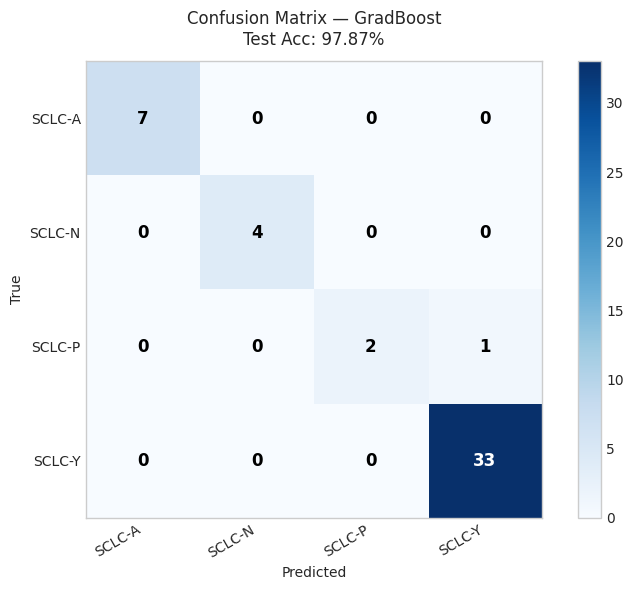


Top features (importance):


,Gene,Importance
2,YAP1,0.3319
0,ASCL1,0.2772
1,NEUROD1,0.1956
3,POU2F3,0.0994
4,INSM1,0.0712
8,BCL2,0.0144
11,CHGA,0.0056
9,DLL3,0.0040
5,MYC,0.0005
6,MYCL,0.0001


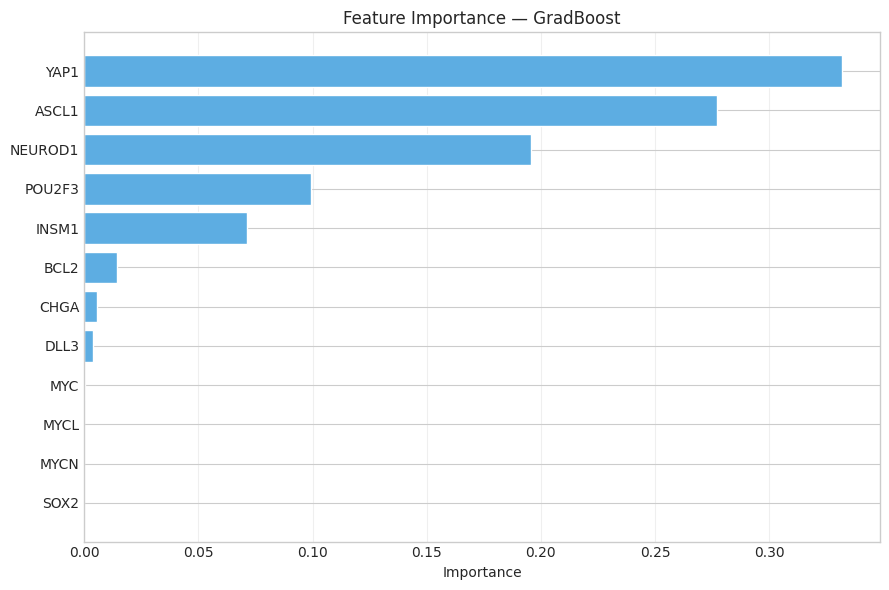

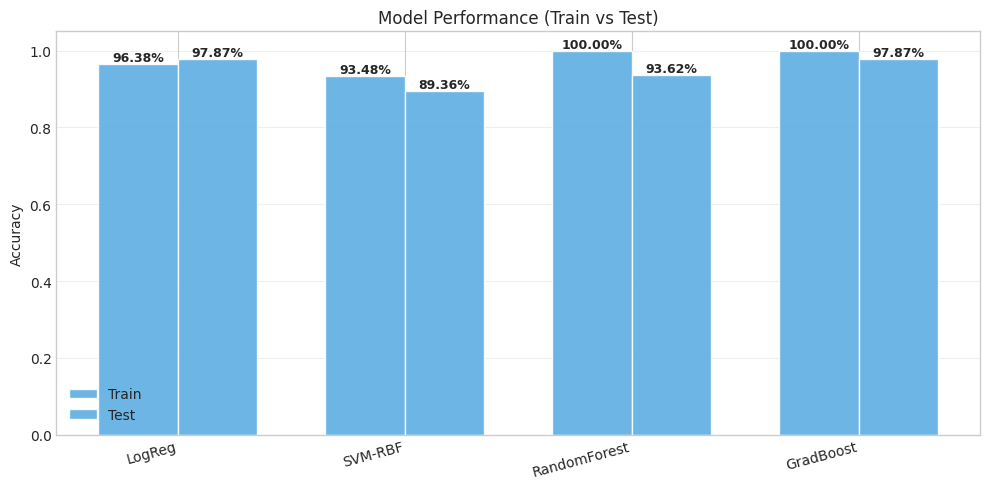


 ML cell complete.


In [12]:
# Cell 12 — ML classifier to predict SCLC subtype (with corrected best-model logic)

print("="*70)
print("🤖 MACHINE LEARNING FOR SCLC SUBTYPE PREDICTION")
print("="*70)

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# ---------- Labels & features ----------
label_col = "Subtype_Zrule" if "Subtype_Zrule" in key_expr.columns else "Predicted_Subtype"
print(f"Using label column: {label_col}")

feature_genes = [
    "ASCL1","NEUROD1","YAP1","POU2F3","INSM1",
    "MYC","MYCL","MYCN",
    "BCL2","DLL3","SOX2","CHGA",
]
features = [g for g in feature_genes if g in key_expr.columns]
assert len(features) >= 4, "Need at least 4 features present."

print(f"\n✓ Using {len(features)} features:\n  " + ", ".join(features))

X = key_expr[features].values
y = key_expr[label_col].values

print("\nClass distribution:")
for s in ["SCLC-A","SCLC-N","SCLC-P","SCLC-Y"]:
    n = (y==s).sum()
    if n > 0: print(f"  {s:6s}: {n:3d}")

# ---------- Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"\nTrain: {X_train.shape[0]}  |  Test: {X_test.shape[0]}")

# ---------- Models (pipelines where scaling is needed) ----------
models = {
    "LogReg": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="ovr", random_state=42)
    ),
    "SVM-RBF": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", class_weight="balanced", probability=False, random_state=42)
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", random_state=42
    ),
    "GradBoost": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.07, random_state=42
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f"\n🔄 Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)

    results[name] = {
        "model": model,
        "train_acc": accuracy_score(y_train, model.predict(X_train)),
        "test_acc": accuracy_score(y_test, y_pred),
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "pred": y_pred,
    }
    print(f"   Train Acc: {results[name]['train_acc']:.2%}")
    print(f"   Test  Acc: {results[name]['test_acc']:.2%}")
    print(f"   CV    Acc: {results[name]['cv_mean']:.2%} ± {results[name]['cv_std']:.2%}")

# ---------- Comparison table ----------
comp = pd.DataFrame(
    {k: [v["train_acc"], v["test_acc"], v["cv_mean"], v["cv_std"]] for k, v in results.items()},
    index=["Train Acc","Test Acc","CV Mean","CV Std"]
).T
comp = comp.sort_values(["Test Acc","CV Mean","CV Std"], ascending=[False, False, True])
print("\nModel comparison:")
display(comp.round(4))

# ---------- Best model (deterministic tie-breakers) ----------
def model_key(m):
    return (
        results[m]["test_acc"],
        results[m]["cv_mean"],
        -results[m]["cv_std"],  # prefer smaller std
    )

best_name = max(results.keys(), key=model_key)
best = results[best_name]
print(f"\n🏆 Best model: {best_name}  |  Test Acc: {best['test_acc']:.2%}  "
      f"(CV: {best['cv_mean']:.2%} ± {best['cv_std']:.2%})")

# ---------- Detailed report ----------
print("\nClassification report (best model):")
print(classification_report(y_test, best["pred"], labels=["SCLC-A","SCLC-N","SCLC-P","SCLC-Y"]))

# Confusion matrix
cm = confusion_matrix(y_test, best["pred"], labels=["SCLC-A","SCLC-N","SCLC-P","SCLC-Y"])
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)
classes = ["SCLC-A","SCLC-N","SCLC-P","SCLC-Y"]
ax.set_xticks(range(4)); ax.set_yticks(range(4))
ax.set_xticklabels(classes, rotation=30, ha="right"); ax.set_yticklabels(classes)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color=("white" if cm[i,j] > cm.max()/2 else "black"),
                fontsize=12, fontweight="bold")
ax.set_title(f"Confusion Matrix — {best_name}\nTest Acc: {best['test_acc']:.2%}", pad=12)
ax.grid(False); plt.tight_layout(); plt.show()

# ---------- Feature importance (trees only) ----------
mdl = results[best_name]["model"]
imp = None
# direct estimator
if hasattr(mdl, "feature_importances_"):
    imp = mdl.feature_importances_
# pipeline with tree inside
elif hasattr(getattr(mdl, "named_steps", {}), "randomforestclassifier"):
    imp = mdl.named_steps["randomforestclassifier"].feature_importances_
elif hasattr(getattr(mdl, "named_steps", {}), "gradientboostingclassifier"):
    imp = mdl.named_steps["gradientboostingclassifier"].feature_importances_

if imp is not None:
    fi = pd.DataFrame({"Gene": features, "Importance": imp}).sort_values("Importance", ascending=False)
    print("\nTop features (importance):")
    display(fi.head(12).round(4))

    fig, ax = plt.subplots(figsize=(9,6))
    ax.barh(fi["Gene"], fi["Importance"])
    ax.invert_yaxis()
    ax.set_xlabel("Importance"); ax.set_title(f"Feature Importance — {best_name}")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout(); plt.show()

# ---------- Train vs Test accuracy chart ----------
fig, ax = plt.subplots(figsize=(10, 5))
model_names = list(results.keys())
train_accs = [results[m]['train_acc'] for m in model_names]
test_accs  = [results[m]['test_acc']  for m in model_names]

x = np.arange(len(model_names)); w = 0.35
b1 = ax.bar(x - w/2, train_accs, width=w, label='Train', alpha=0.9)
b2 = ax.bar(x + w/2, test_accs,  width=w, label='Test',  alpha=0.9)

ax.set_ylabel('Accuracy'); ax.set_title('Model Performance (Train vs Test)')
ax.set_xticks(x); ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.set_ylim(0, 1.05); ax.grid(axis='y', alpha=0.3); ax.legend()

for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2%}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout(); plt.show()

print("\n ML cell complete.")